#**ResNet Training (CIFAR - 10)**

###**1. Import Library & Define Resnet model**

In [1]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

###**2. Download CIFAR-10**

In [2]:
#Download CIFAR10 DATASET

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 

    transforms.ToTensor(), normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(), normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


###**3. CUDA setting & Define Train,Test function**

In [3]:
#gpu setting & define Training function

device = 'cuda'

net = resnet101(3,10)           #resnet101 선언
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet101_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    total_accuracy = 100. * correct / total;

    return total_accuracy , train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)
    total_accuracy = 100. * correct / total;
    test_loss = loss / total

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_accuracy , test_loss

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

###**4. Run Training & Save log**

In [4]:
# for epoch in range(0, 60):
log_train_total_accuracy =[]
log_train_total_loss = []
log_test_total_accuracy =[]
log_test_total_loss =[]


for epoch in range(0, 60):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.09375
Current benign train loss: 2.7471818923950195

Current batch: 100
Current benign train accuracy: 0.1015625
Current benign train loss: 6.04228401184082

Current batch: 200
Current benign train accuracy: 0.1484375
Current benign train loss: 2.2906529903411865

Current batch: 300
Current benign train accuracy: 0.1484375
Current benign train loss: 2.141526460647583

Total benign train accuarcy: 15.502
Total benign train loss: 4175.9759068489075

[ Test epoch: 0 ]

Test accuarcy: 20.03
Test average loss: 0.021302223753929136
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.125
Current benign train loss: 2.2148842811584473

Current batch: 100
Current benign train accuracy: 0.234375
Current benign train loss: 2.098637580871582

Current batch: 200
Current benign train accuracy: 0.21875
Current benign train loss: 2.140054702758789

Current batch: 300
Current benign train accuracy: 0.1

###**Additional Learning**

In [4]:
file_name = "/content/checkpoint/resnet101_cifar10.pt"
device = 'cuda'

net = resnet101(3,10)
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

file_name = 'resnet101_cifar10.pt'

# Reloading previous log
log_train_total_accuracy = [15.502, 20.342, 22.106, 24.676, 28.464, 30.564, 32.494, 34.348, 36.12, 39.07, 41.202, 42.966, 44.356, 45.718, 47.574, 48.518, 49.948, 51.778, 53.468, 55.162, 56.554, 58.244, 60.982, 62.292, 62.484, 63.974, 64.732, 65.872, 67.222, 68.01, 67.622, 69.14, 70.41, 70.666, 71.286, 71.984, 72.38, 72.76, 73.204, 73.554, 73.924, 74.058, 74.55, 74.562, 75.208, 75.388, 75.936, 75.988, 75.914, 76.592, 76.412, 76.492, 77.076, 76.908, 77.16, 77.37, 77.462, 77.698, 77.758, 78.094]
log_train_total_loss = [4175.9759068489075, 830.6173853874207, 809.0841267108917, 779.2030724287033, 736.6709563732147, 716.1709477901459, 697.9976419210434, 678.5618153810501, 660.9197375774384, 637.4977751970291, 616.7866654396057, 601.8166383504868, 590.379266500473, 578.5205208063126, 560.9697985649109, 550.8708676099777, 534.9371531009674, 518.9586350917816, 502.13169598579407, 486.5178962945938, 473.2489016056061, 456.7028287053108, 429.3801029920578, 414.95238494873047, 415.4579593539238, 396.0112069249153, 389.71844828128815, 377.25158590078354, 364.3613389134407, 353.7557737827301, 360.69744724035263, 341.3494316935539, 330.20994514226913, 330.6394282579422, 322.4163251519203, 314.39684957265854, 310.08860474824905, 305.8979754447937, 300.3778737783432, 297.225270986557, 294.71638453006744, 292.175458997488, 288.0069160461426, 286.96395418047905, 280.4942251443863, 278.7564867734909, 275.4174501299858, 273.2104496061802, 271.84637743234634, 268.1085234284401, 267.423605799675, 266.2192108333111, 260.6468726694584, 261.4424318373203, 260.1812582015991, 257.70074144005775, 255.21400594711304, 254.06024107336998, 252.8576533794403, 251.2927948832512]
log_test_total_accuracy = [20.03, 22.62, 25.3, 27.39, 30.45, 33.82, 35.45, 35.03, 40.09, 40.85, 41.71, 45.1, 43.56, 49.56, 49.23, 49.81, 51.72, 49.46, 55.06, 54.88, 57.18, 56.52, 62.18, 62.96, 58.66, 65.83, 57.18, 63.78, 64.46, 66.67, 66.22, 66.02, 70.01, 68.79, 70.46, 70.86, 71.46, 71.66, 71.82, 70.01, 73.82, 71.96, 73.44, 73.39, 70.5, 75.1, 71.4, 74.29, 73.84, 69.38, 75.36, 74.05, 74.78, 76.13, 76.14, 71.09, 74.45, 77.43, 75.82, 75.17]
log_test_total_loss = [0.021302223753929136, 0.020561138129234314, 0.020122406017780304, 0.019305508184432982, 0.019113454186916352, 0.018735235035419465, 0.01760292009115219, 0.01815764602422714, 0.016217864954471587, 0.017535923337936403, 0.01692174918651581, 0.01625846029520035, 0.015504594731330871, 0.014179882383346557, 0.014803030455112456, 0.014093189024925233, 0.01337302234172821, 0.015988504576683046, 0.012797817361354828, 0.012740416914224624, 0.014552570444345474, 0.012379107934236527, 0.010891082853078842, 0.010785517591238022, 0.012343842548131943, 0.009821498233079911, 0.021949407124519347, 0.01050003113746643, 0.010329653871059418, 0.009472766733169555, 0.009763298445940018, 0.010168548363447188, 0.008603241688013076, 0.009020485025644303, 0.00863970485329628, 0.008511634474992752, 0.008366303724050521, 0.008134137761592865, 0.008268313041329384, 0.008800289356708527, 0.007671137619018555, 0.008214073538780212, 0.007735125064849854, 0.00791269463300705, 0.008890336388349534, 0.007129003927111625, 0.008751053285598755, 0.007429182478785515, 0.00761370964050293, 0.009418480163812637, 0.007085722073912621, 0.007715022364258767, 0.007614614948630333, 0.006990804603695869, 0.006903522264957428, 0.008636319899559021, 0.007764909636974335, 0.006568957871198654, 0.0072239441603422164, 0.007405026918649673]

for epoch in range(0, 40):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.765625
Current benign train loss: 0.5809906721115112

Current batch: 100
Current benign train accuracy: 0.8203125
Current benign train loss: 0.5587702393531799

Current batch: 200
Current benign train accuracy: 0.7265625
Current benign train loss: 0.8315163850784302

Current batch: 300
Current benign train accuracy: 0.6953125
Current benign train loss: 0.8773695826530457

Total benign train accuarcy: 78.13
Total benign train loss: 246.90174108743668

[ Test epoch: 0 ]

Test accuarcy: 77.7
Test average loss: 0.006559841763973236
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.75
Current benign train loss: 0.7279883027076721

Current batch: 100
Current benign train accuracy: 0.796875
Current benign train loss: 0.6367774605751038

Current batch: 200
Current benign train accuracy: 0.765625
Current benign train loss: 0.6656354665756226

Current batch: 300
Current benign train accuracy:

###**5. Plotting Train Accuracy & Loss**

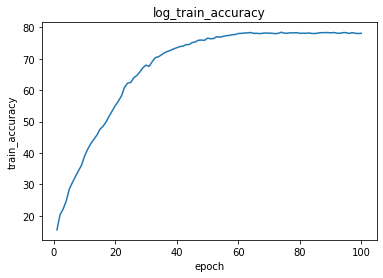

In [5]:
epoch =[]

for i , loss in enumerate(log_test_total_loss):
  epoch.append(i+1)

import matplotlib.pyplot as plt

plt.title('log_train_accuracy')
plt.plot(epoch , log_train_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.show()  

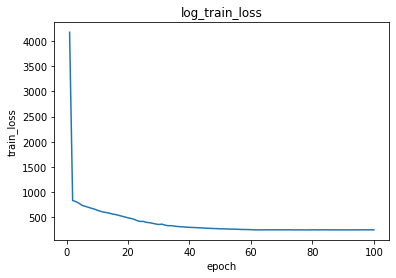

In [6]:
import matplotlib.pyplot as plt

plt.title('log_train_loss')
plt.plot(epoch , log_train_total_loss)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

###**6. Plotting Test Accuracy & Loss**

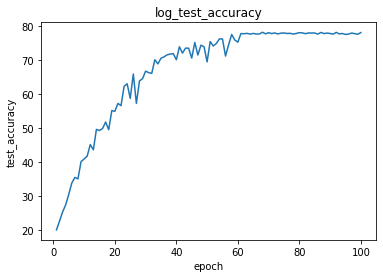

In [7]:
import matplotlib.pyplot as plt

plt.title('log_test_accuracy')
plt.plot(epoch , log_test_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()

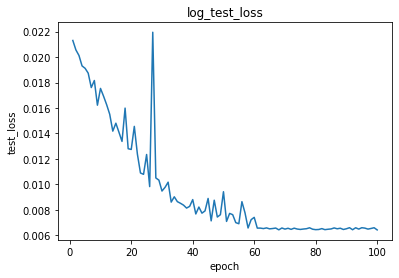

In [8]:
import matplotlib.pyplot as plt

plt.title('log_test_loss')
plt.plot(epoch , log_test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.show()

###**7. Print Result**

In [9]:
print(log_train_total_accuracy)
print(log_train_total_loss) 
print(log_test_total_accuracy)
print(log_test_total_loss)

[15.502, 20.342, 22.106, 24.676, 28.464, 30.564, 32.494, 34.348, 36.12, 39.07, 41.202, 42.966, 44.356, 45.718, 47.574, 48.518, 49.948, 51.778, 53.468, 55.162, 56.554, 58.244, 60.982, 62.292, 62.484, 63.974, 64.732, 65.872, 67.222, 68.01, 67.622, 69.14, 70.41, 70.666, 71.286, 71.984, 72.38, 72.76, 73.204, 73.554, 73.924, 74.058, 74.55, 74.562, 75.208, 75.388, 75.936, 75.988, 75.914, 76.592, 76.412, 76.492, 77.076, 76.908, 77.16, 77.37, 77.462, 77.698, 77.758, 78.094, 78.13, 78.236, 78.284, 78.398, 78.136, 78.146, 78.052, 78.18, 78.25, 78.198, 78.148, 78.046, 78.142, 78.488, 78.178, 78.192, 78.314, 78.272, 78.364, 78.134, 78.182, 78.164, 78.256, 78.088, 78.096, 78.25, 78.358, 78.38, 78.378, 78.294, 78.41, 78.202, 78.142, 78.366, 78.37, 78.11, 78.34, 78.178, 78.068, 78.156]
[4175.9759068489075, 830.6173853874207, 809.0841267108917, 779.2030724287033, 736.6709563732147, 716.1709477901459, 697.9976419210434, 678.5618153810501, 660.9197375774384, 637.4977751970291, 616.7866654396057, 601.816

###**8. Model Summary**

In [10]:
from torchsummary import summary

model = resnet101(3, 10)
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]          16,384
       BatchNorm2d-6            [-1, 256, 8, 8]             512
        Conv2dAuto-7             [-1, 64, 8, 8]           4,096
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
       Conv2dAuto-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
       Conv2dAuto-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25